# Denoising autoencoder

We are going to use ```keras``` (```tensorflow``` as backend) to build a simple denoising autoencoder.

## Libraries
We'll be using Pillow a fork of PIL, the Python Image Library, Tensorflow, Numpy and Matplotlib.
You can install Pillow with
```
!pip install Pillow
```

## Imports

In [24]:
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Data

### Load and check the data

In [25]:
# load the data
(x_train, _), (x_test, _) = mnist.load_data()

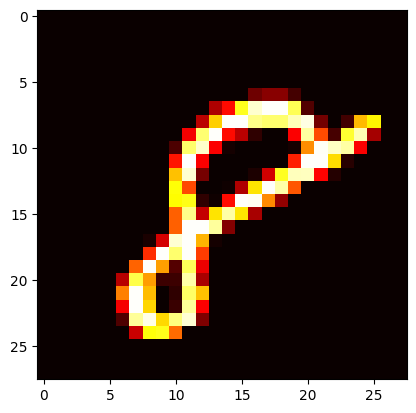

In [26]:
imgplot = plt.imshow(x_train[-1], cmap='hot')
# use imgshow, with the formats, like 2 dimensional or to quickly show.
# IMGshow is great.

In [27]:
# reshape an image. Minus 1 means since we know 60000 by 60000, first dimension can be automatically computed.
x_train.reshape(-1,28,28,1).shape

(60000, 28, 28, 1)

In [28]:
# Copy to new shape. Do the same
x_train = x_train.reshape(-1,28,28,1) # added an empty dimension
x_test = x_test.reshape(-1,28,28,1)

In [29]:
# Exploding gradient - better to have everything between zero and 1
# How to normalize it

(x_train / (255)).min()

0.0

In [30]:
(x_train / (255)).max()

1.0

In [31]:
# Normalize. Would be better to do min/max, 1 by 255.

x_train = x_train / 255 # normalized
x_test = x_test / 255 # normalized


#### Take a look at the data

Just look at one or two examples to get an idea of the data.

### Reshape the images

When loaded, each image is 2-dimensional, 28 x 28 pixels. But, due to how keras and tensorflow handles images we want the images to have the shape 28 x 28 x num_channels, where num_channels is the number of color channels in the images. These are grey scale images so the num_channels is 1, but in colour images num_channels is 3 (RGB).

### Normalize the input data
Check the range of values and data type (```dtype```) or the input data.

Is this ok, or should we normalize the data?

What about the data type?

### Generate corrupted MNIST images

Add noise with normal distribution centered at 0.5 and std=0.5

In [32]:
# Generate noise for normal dist centered around 0.5, and std is 0.5
# We want the total matrix to be the same shape as X_Train

# np.random, increase the scale; check what loc and scale mean

x_train_noisy = x_train + np.random.normal(loc = 0.5, scale = 5, size = x_train.shape)
x_test_noisy = x_test + np.random.normal(loc = 0.5, scale = 5, size = x_test.shape)

# Loc and Scale

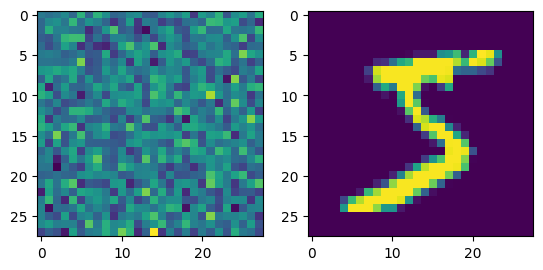

In [33]:
# How to check the level of noisyness?
# Solution - plot the image before and after the noise

fig = plt.figure()
ax = fig.add_subplot(1,2,1) # 1 row, 2 columns, 1st image
plt.imshow(x_train_noisy[0])
ax = fig.add_subplot(1,2,2) # add second axis, 2nd image
plt.imshow(x_train[0])


### Check the corrupted images

## Model

### Build the model
Use ```Sequential()``` and add two encoder layers, one hidden/middle layer, and two decoder layers.
For the layers, use ```Dense()```, i.e. densly connected layers (not convolutional or dropout).

In [34]:
# Network parameters
input_shape = x_train.shape[1:] # latent dimension is the one in the middle
batch_size = 128
kernel_size = 3
latent_dim = 16
# Encoder/Decoder number of CNN layers and filters per layer (depth)
layer_filters = [32, 64] # first layer will have 32 filters, next one is 64 filters

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters, # pass the filters
               kernel_size=kernel_size,
               strides=2, # same stuff, strides decided, then we have to get the shape
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model - get shape
shape = K.int_shape(x)

# Generate the latent vector - flatten it to 1 dimensional
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model #  - make the encoder
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Build the Decoder Model - build the deocder - output of decoder is input of the encoder
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

# Build the layer back to

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# encoder steps noted below in layer - everything until latent vector is considered the "encoder" part of the diagram
# deocer steps noted below - everything except the last layer is considered decodder part of the diagram


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_vector (Dense)                │ (None, 16)                  │          50,192 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,008 (269.56 KB)

 Trainable params: 69,008 (269.56 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3136)                │          53,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Activation)          │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,993 (425.75 KB)

 Trainable params: 108,993 (425.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 16)                  │          69,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │         108,993 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,001 (695.32 KB)

 Trainable params: 178,001 (695.32 KB)

 Non-trainable params: 0 (0.00 B)

### Compile and train

In [36]:
autoencoder.compile(loss='mse', optimizer='adam')

In [37]:
# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=30,
                batch_size=batch_size)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0784 - val_loss: 0.0673
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0660 - val_loss: 0.0645
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0640 - val_loss: 0.0642
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0633 - val_loss: 0.0640
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0629 - val_loss: 0.0641
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0624 - val_loss: 0.0643
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0620 - val_loss: 0.0644
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0615 - val_loss: 0.0647
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0610 - val_loss: 0.0655
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0605 - val_loss: 0.0654
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0601 - val_loss: 0.0658
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/ste

## Test

### Test our brand new denoiser

Pro-tip: use ```model.predict()```

and take a look at the result (try plotting the original and reconstructed images next to each other)

**Are we doing denoising?**

Add some noise to a test image and try to reconstruct it.
Pro-tip:
    Use ```np.random.something```
    
Plot the original, noise added and reconstructed images side-by-side

In [38]:
# Predict with noise
x_test_cleaned = autoencoder.predict(x_test_noisy)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[]

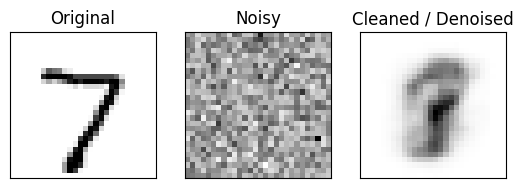

In [39]:
fig = plt.figure()
ax = fig.add_subplot(1,3,1) # 1 row, 2 columns, 1st image
ax.set_title('Original')
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x_test[0], cmap='Greys') # test image
ax = fig.add_subplot(1,3,2) # add second axis, 2nd image
ax.set_title('Noisy')
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x_test_noisy[0], cmap='Greys') # noisy test
ax = fig.add_subplot(1,3,3) # add second axis, 2nd image
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(x_test_cleaned[0], cmap='Greys') # cleaned results
ax.set_title('Cleaned / Denoised')
ax.set_xticks([])
ax.set_yticks([])

In [40]:
# Can we add even more noise?
# yes!

# Remove Gaussian Noise
# if you add more noise, shape of noise
# But it's great at Gaussian Noise
